In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.python.keras import backend as K
from tensorflow import keras
import pandas as pd
import numpy as np


def one_hot_encode(df, col='seq', seq_len=44):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        lst = [nuc_d[x] for x in seq]
        if seq_len>len(seq):
            lst += [nuc_d['n']]*(seq_len-len(seq))
        a = np.array(lst)
        vectors[i] = a
    return vectors
datadir=f"/Users/john/data/Promter/results"
# name,seq_len="pl3-1-2",23
# df = pd.read_csv(f"{datadir}/final_d5c_sample.csv")
# keras_model = keras.models.load_model("./models/pl53_core.keras")
name,seq_len="pl3-1-2",118
df = pd.read_csv(f"{datadir}/final_d5_sample.csv")
keras_model = keras.models.load_model("/Users/john/data/models/pl3-1-2.keras")
input_data = one_hot_encode(df,seq_len=seq_len)
seqs=df["seq"].values

2024-09-01 21:21:53.096540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(10, 118, 4)


Text(0, 0.5, 'high')

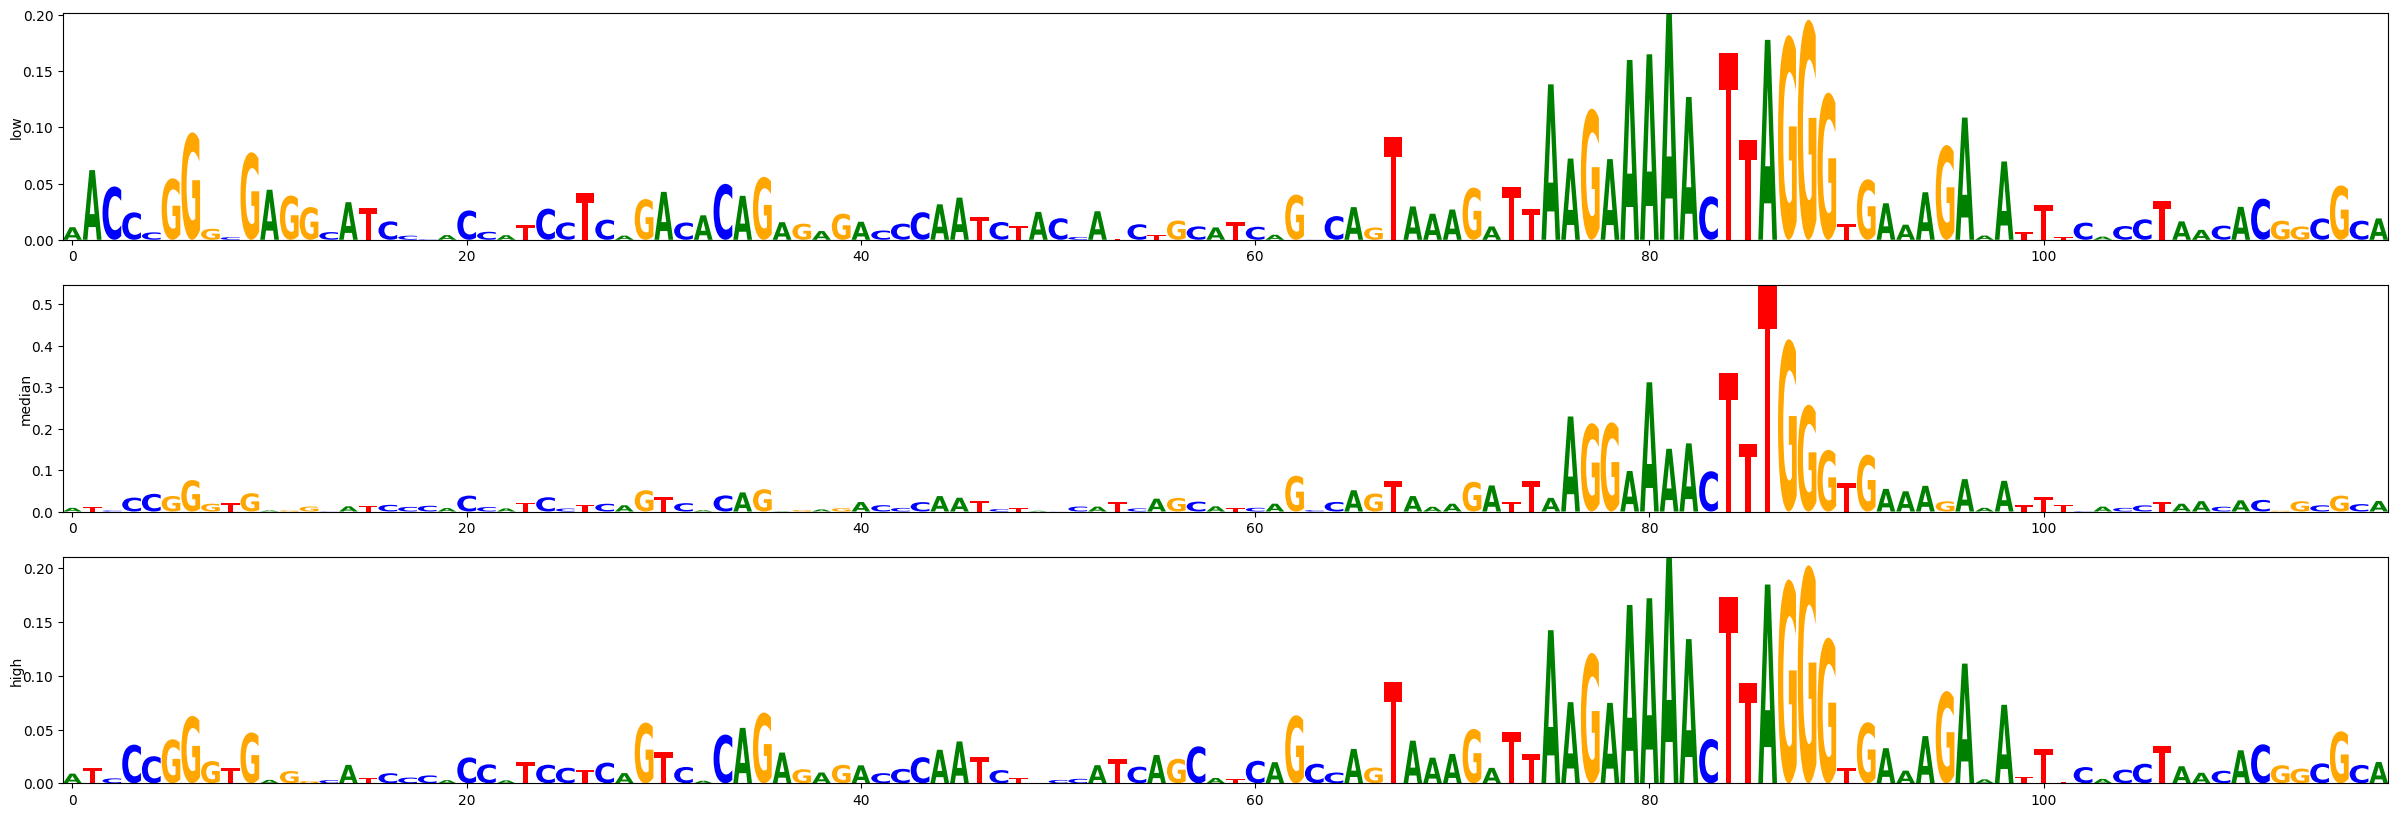

In [2]:
import logomaker
import matplotlib.pyplot as plt
import seaborn as sns

def grad_causual(input_data, keras_model):
    input_tensor = tf.convert_to_tensor(input_data)
    output_tensor = keras_model(input_tensor)  # 或者 model.output 计算整体输出
    # 如果您只对某一类的输出感兴趣，可以选取该类的输出：
    # category_index = 0  # 假设类别的索引为0
    # output_tensor = output_tensor[:, category_index]

    # 计算输出相对于输入的梯度
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)  # 使得输入张量可微分
        output = keras_model(input_tensor)  # 前向传播

    gradients = tape.gradient(output, input_tensor)  # 计算梯度
    # 将梯度转换为numpy数组并输出
    return gradients.numpy()

gradients_np =grad_causual(input_data, keras_model)
print(gradients_np.shape)
scores=abs(input_data*gradients_np)
fig, axs = plt.subplots(3, 1, figsize=(30,10))
seq_df = pd.DataFrame(scores[0],columns=['A','C','G','T'])
logo=logomaker.Logo(seq_df,ax=axs[0])
logo.ax.set_ylabel("low", labelpad=-1)
seq_df = pd.DataFrame(scores[3],columns=['A','C','G','T'])
logo=logomaker.Logo(seq_df,ax=axs[1])
logo.ax.set_ylabel("median", labelpad=-1)
seq_df = pd.DataFrame(scores[9],columns=['A','C','G','T'])
logo=logomaker.Logo(seq_df,ax=axs[2])
logo.ax.set_ylabel("high", labelpad=-1)

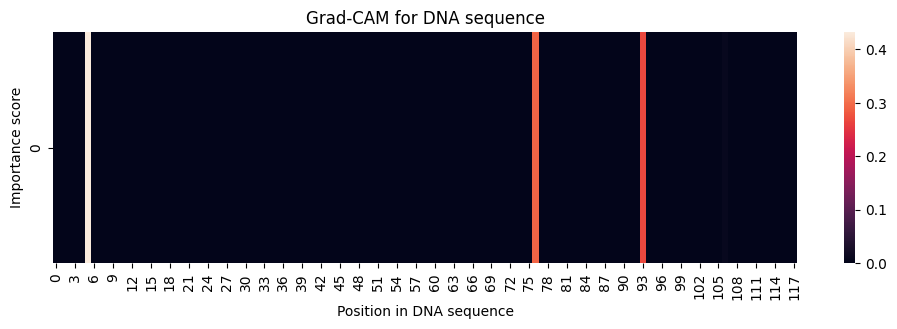

In [3]:
def compute_gradcam(input_data,model,layer_name=None):
    input_tensor = tf.convert_to_tensor(input_data)
    # 计算指定类别相对于最后一个卷积层输出的梯度
    layer_names=[v.name for v in model.layers]
    if not layer_name:
        layer_name = [ v for v in layer_names if v.startswith('conv')][-1]
    grad_model = tf.keras.models.Model(model.inputs, model.get_layer(layer_name).output)
    regress_input = tf.keras.Input(shape=model.get_layer(layer_name).output.shape[1:])
    regress_output = regress_input
    for lname in layer_names[layer_names.index(layer_name)+1:-1]:
        regress_output = model.get_layer(lname)(regress_output)
    regress_model = tf.keras.Model(regress_input, regress_output)
    with tf.GradientTape() as tape:
        conv_outputs= grad_model(input_tensor)
        tape.watch(conv_outputs)
        predictions = regress_model(conv_outputs)
    grads=tape.gradient(predictions, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(1,))
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def plot_dna_gradcam(heatmap, sequence=""):
    plt.figure(figsize=(12, 3))
    sns.heatmap(heatmap, color='red')
    plt.title("Grad-CAM for DNA sequence")
    plt.xlabel("Position in DNA sequence")
    plt.ylabel("Importance score")
    plt.show()

heatmap=compute_gradcam(input_data,keras_model)
# heatmap.shape
plot_dna_gradcam(heatmap[0][:,np.newaxis].T)
# scores=abs(heatmap[...,np.newaxis]*input_data)
# scores=abs(heatmap[...,np.newaxis]*input_data)
# fig, axs = plt.subplots(3, 1, figsize=(30,10))
# seq_df = pd.DataFrame(scores[0],columns=['A','C','G','T'])
# logo=logomaker.Logo(seq_df,ax=axs[0])
# logo.ax.set_ylabel("low", labelpad=-1)
# seq_df = pd.DataFrame(scores[3],columns=['A','C','G','T'])
# logo=logomaker.Logo(seq_df,ax=axs[1])
# logo.ax.set_ylabel("median", labelpad=-1)
# seq_df = pd.DataFrame(scores[9],columns=['A','C','G','T'])
# logo=logomaker.Logo(seq_df,ax=axs[2])
# logo.ax.set_ylabel("high", labelpad=-1)

Scores for example[Low]:


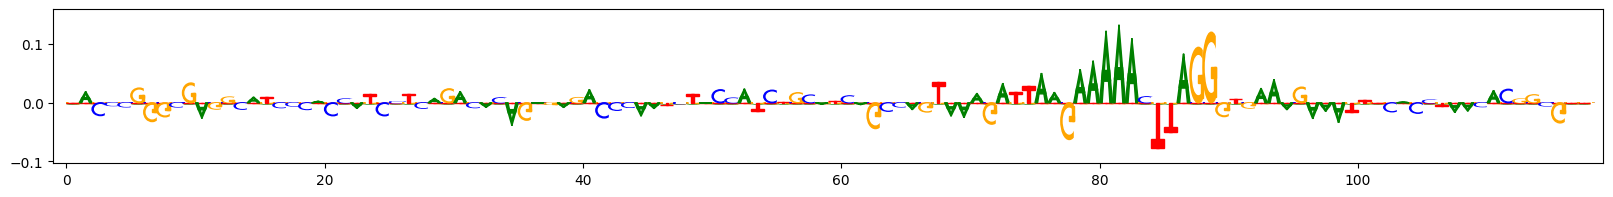

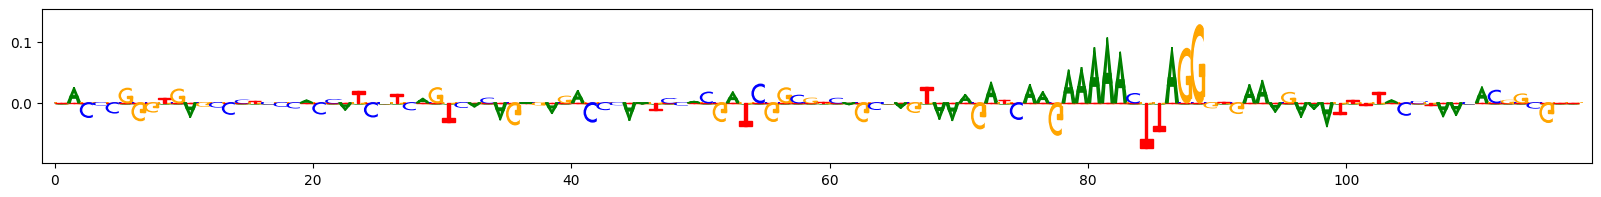

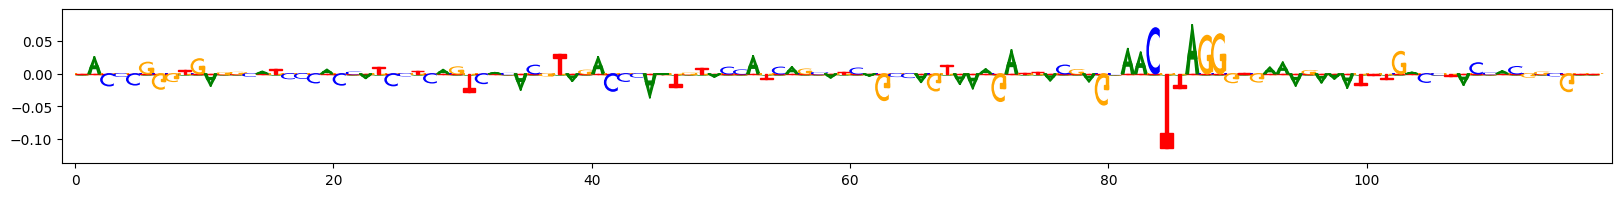

Scores for example[Middle]:


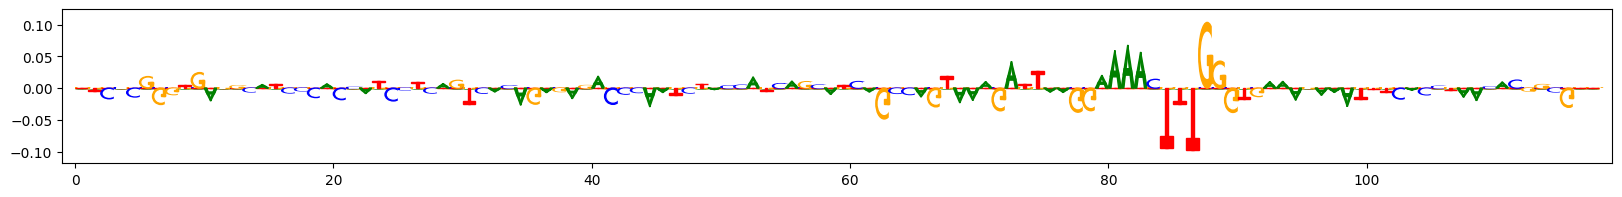

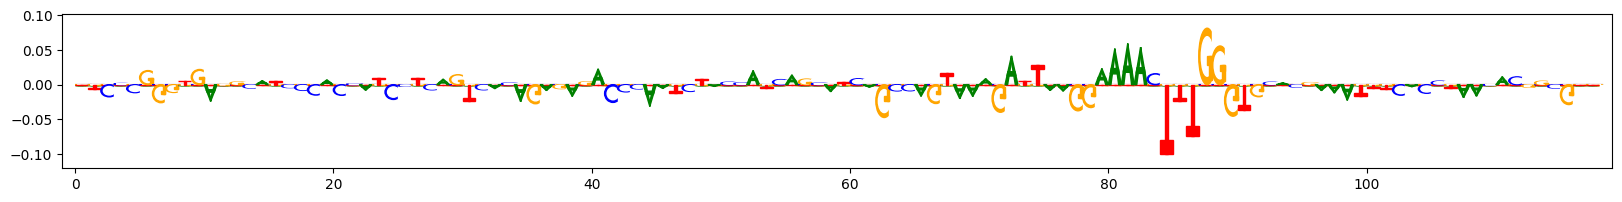

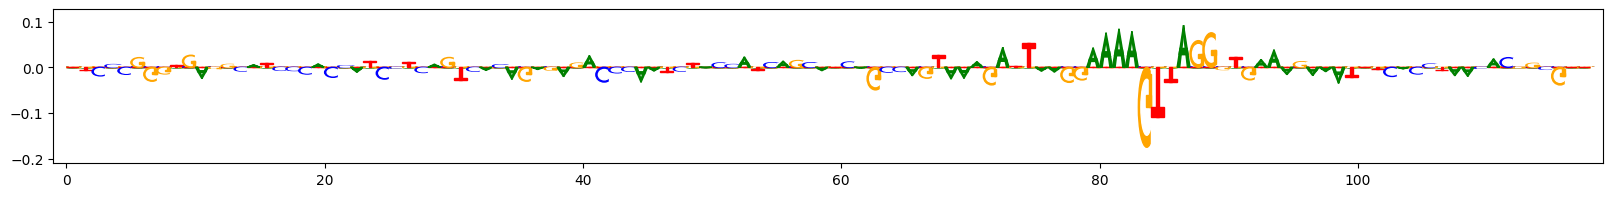

Scores for example[High]:


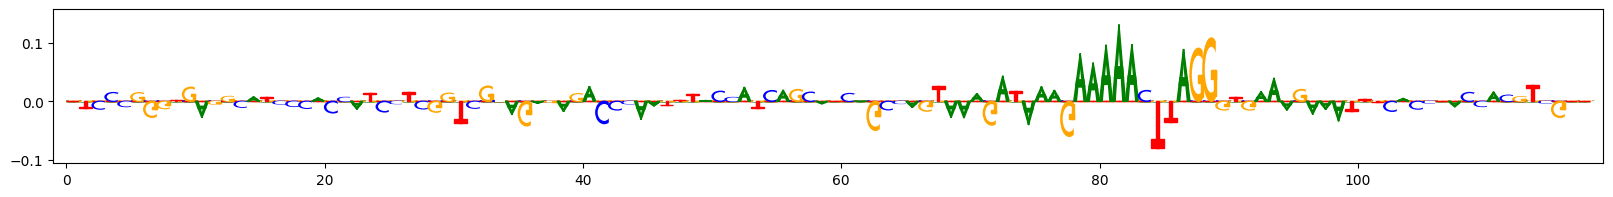

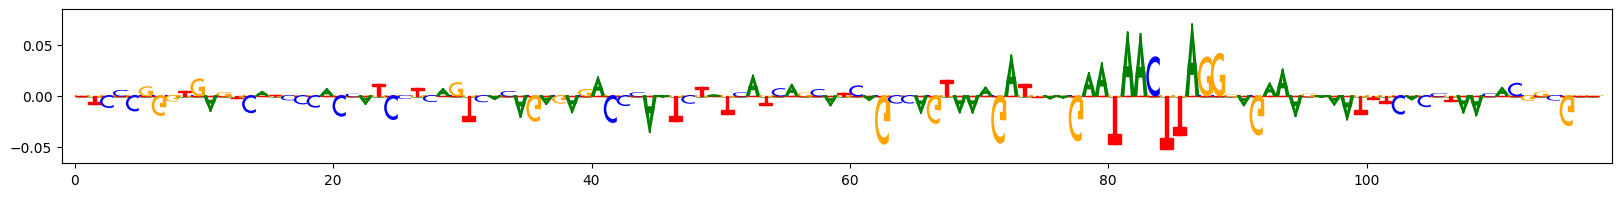

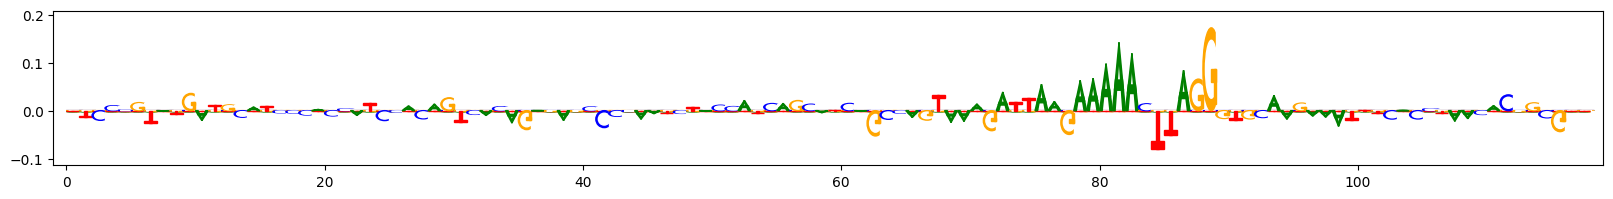

Scores for example[Raw]:


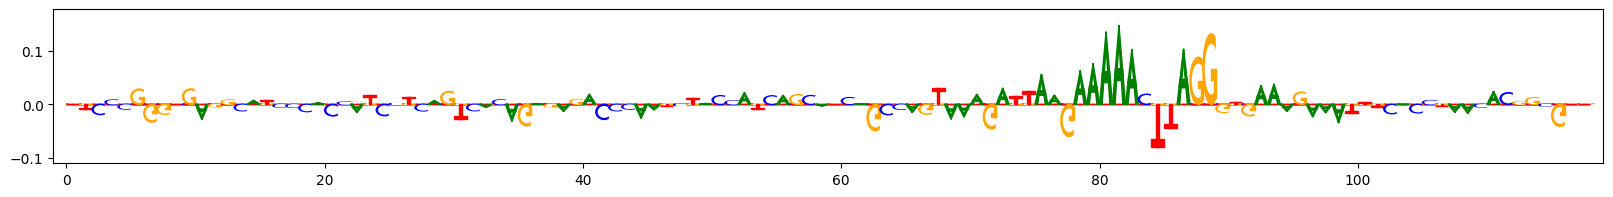

In [6]:
import os
import warnings
import tensorflow as tf
tf.get_logger().setLevel("ERROR")
warnings.simplefilter("ignore")
from tensorflow import keras
import pandas as pd
import numpy as np
import shap
from deeplift.dinuc_shuffle import dinuc_shuffle
from deeplift.visualization import viz_sequence


def shuffle_several_times(s):
    s = np.squeeze(s)
    return dinuc_shuffle(s, num_shufs=100)


np.random.seed(1)
seqs_to_explain = input_data[list(range(len(df)))]  # these three are positive for task 0
dinuc_shuff_explainer = shap.DeepExplainer((keras_model.inputs[0], keras_model.outputs[0][:, 0]), shuffle_several_times)
raw_shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain, check_additivity=False)

# project the importance at each position onto the base that's actually present
# dinuc_shuff_explanations = np.sum(raw_shap_explanations, axis=-1)[:, :, None] * seqs_to_explain
dinuc_shuff_explanations = np.sum(raw_shap_explanations, axis=-1) * seqs_to_explain
for idx, dinuc_shuff_explanation in zip(list(range(len(df))), dinuc_shuff_explanations):
    if idx % 3==0:
        stype = "High" if idx>=6 else  "Middle" if idx>=3 else "Low"
        stype = "Raw" if idx==9 else stype
        print(f"Scores for example[{stype}]:")
#     highlight = {"blue": [(73,96)],}
#     viz_sequence.plot_weights(dinuc_shuff_explanation, subticks_frequency=20,highlight=highlight)
    viz_sequence.plot_weights(dinuc_shuff_explanation, subticks_frequency=20)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


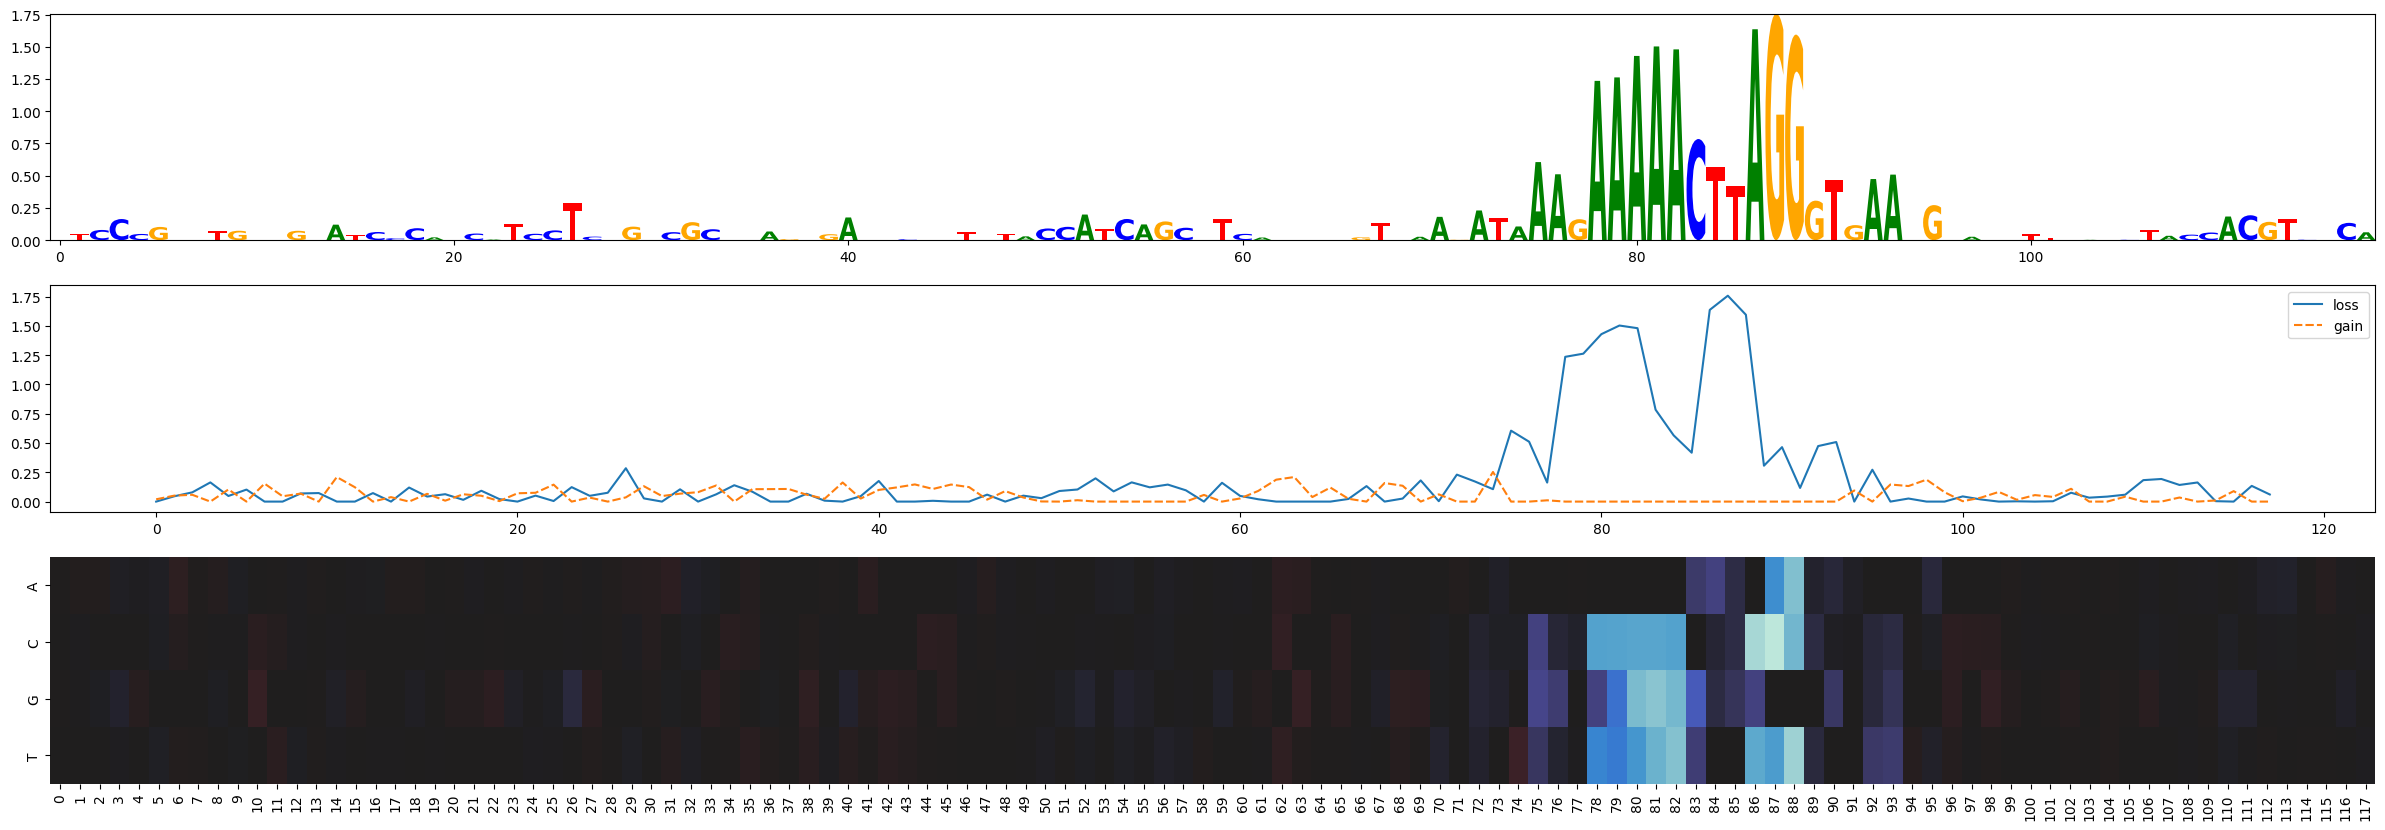

In [7]:
import h5py
import logomaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# original_seq = 'atcccgggtgaggcatcccaccatcctcagtcacagagagacccaatctaccatcagcatcagccagtaaagattaagaaaaacttagggtgaaagaaatttcacctaacacggcgca'
original_seq=seqs[6].lower()
seqs = []
nucs = "acgt"
dnucs={"a":0,"c":1,"g":2,"t":3}
for i,n in enumerate(original_seq):
    for k in nucs:
        seq = original_seq[:i]+k+original_seq[i+1:]
        seqs.append(seq)
# nucs=list(itertools.permutations("acgt",2))
# for i in range(118):
#     for j in range(i+1,118):
#         for f,s in nucs:
#             print(i,j)
#             seq = original_seq[:i]+f+original_seq[i+1:j]+s+original_seq[j+1:]
#             seqs.append(seq)
seq_len=118
df = pd.DataFrame(data={"seq":seqs})
onehot_data = one_hot_encode(df,seq_len=seq_len)
scores = keras_model.predict(onehot_data)
df["score"] = scores
rscore = df[df.seq==original_seq].iloc[0].score
df["score"] = df["score"]-rscore
gain=df["score"].values.reshape((118,-1)).max(axis=1)
loss = abs(df["score"].values.reshape((118,-1)).min(axis=1))
input_raw = np.zeros((118,4))
dnucs={"a":0,"c":1,"g":2,"t":3}
idxs = [ dnucs[v.lower()] for v in original_seq]
input_raw[range(118),idxs]=1
sdf = pd.DataFrame(index=range(118),data={"loss":loss,"gain":gain})

scores_ref=df["score"].values.reshape((-1,4))


def plot_logo(sdf,scores, viz_len=None):
    loss_ref=input_raw*sdf["loss"].values[:,np.newaxis]
    fig, axs = plt.subplots(3, 1, figsize=(30,10))
    scores=scores.reshape(118,4)
    seq_df = pd.DataFrame(loss_ref,columns=['A','C','G','T'])
    seq_logo = logomaker.Logo(seq_df, ax=axs[0])
    sns.lineplot(data=sdf[["loss","gain"]], ax=axs[1])
    sns.heatmap(scores.T, center=0, cbar=False, ax=axs[2])
    axs[2].set_yticklabels('ACGT')
    return seq_df

# scores_ref=df["score"].values.reshape((-1,4))
seq_df=plot_logo(sdf,scores_ref, 118)
